## Low regret strategies for the use of biomass in the European energy transition
### Master's Thesis Oliver Keller 2024

### Preparation
Use the julia code which can be found under https://github.com/oliver-keller/EuSysMod to create the scenarios you want and run the optimization model. The outputsOfInterest.csv file contains the different usage categories in the different columns and the iterations in the rows. This file must be copied into the DECIDE directory to run this script.

Now import all the needed libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import cdist, euclidean
from tabulate import tabulate
import os

from utilities.produce_interpretable_tree import produce_interpretable_tree

Next we read in the data and specify/create an output directory

In [2]:
df_input = pd.read_csv("outputsOfInterest.csv", sep=",") # Read the CSV file
df_input = df_input.drop(columns=['iteration']) # Drop the iteration column
df_input= df_input.abs() # Take the absolute value of all columns

folder = "./biomass_results/"
if not os.path.exists(folder): # Create the folder if it does not exist
    os.makedirs(folder)

## combine categories
df_input['LTH'] = df_input['LTH'] + df_input['DH'] + df_input['SpaceHeating'] # Combine 'LTH', 'DH', and 'SpaceHeating' columns
df_input = df_input.drop(columns=['DH', 'SpaceHeating']) # Drop the original 'DH' and 'SpaceHeating' columns
df_input['HTH'] = df_input['MTH'] + df_input['HTH'] # Combine 'MTH' and 'HTH' 
df_input = df_input.drop(columns=['MTH']) # Drop the original 'DH' and 'SpaceHeating' columns

Now we create a visualization of the data in a table showing the maximum and minimum of each category. 
Next the categories with low biomass usage (below 10% of highest max value) are filtered out and a spiderplot is created showing the biomass usage of the relevant categories.

In [3]:
## Create a taple with the max and min values of each column
# Calculate the max and min values for each column
data_max = df_input.max().values
data_min = df_input.min().values

# Create a list of lists with column name, max value, and min value
table_data = []
for column in df_input.columns:
    max_value = df_input[column].max()
    min_value = df_input[column].min()
    table_data.append([column, max_value, min_value])

# Print the table
print(tabulate(table_data, headers=["Column Name", "Max Value", "Min Value"], tablefmt="grid"))

+---------------+-------------+-------------+
| Column Name   |   Max Value |   Min Value |
+===============+=============+=============+
| crudeOil      |  453.562    |     123.424 |
+---------------+-------------+-------------+
| HVC           |  620.844    |     335     |
+---------------+-------------+-------------+
| CHP           |    2.90991  |       0     |
+---------------+-------------+-------------+
| LTH           |    1.1405   |       0     |
+---------------+-------------+-------------+
| HTH           |    1.26135  |       0     |
+---------------+-------------+-------------+
| rawBiogas     |    1.44388  |       0     |
+---------------+-------------+-------------+
| syngas        |  232.313    |       0     |
+---------------+-------------+-------------+
| coal          |    0.243697 |       0     |
+---------------+-------------+-------------+


In [4]:
## Filter not relevant columns
# Filter the columns with higher max_value than 10% of the highest max_value
highest_max_value = max(data_max)
filtered_columns = [column for column, max_value, _ in table_data if max_value > 0.1 * highest_max_value]

# Remove the columns with too low values
df_filtered = df_input[filtered_columns]

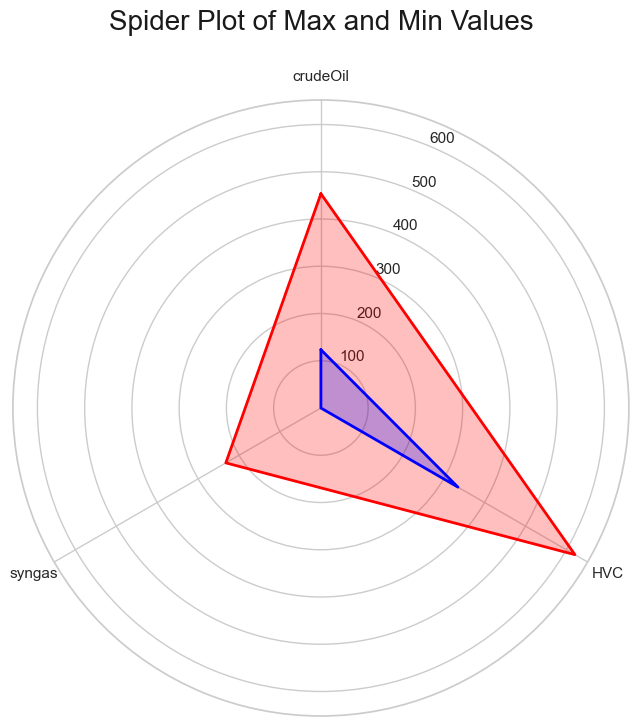

In [5]:
## Create a radar plot showing the max and min values of the relevant columns
# Calculate the max and min values for each column
data_max_filtered = df_filtered.max().values
data_min_filtered = df_filtered.min().values

# Number of variables
num_vars = len(df_filtered.columns)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Initialize the radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Draw one axe per variable + add labels
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], df_filtered.columns)

# Plot data
values_max = data_max_filtered.tolist()
values_max += values_max[:1]
ax.plot(angles, values_max, color='red', linewidth=2, linestyle='solid', label='Max')

values_min = data_min_filtered.tolist()
values_min += values_min[:1]
ax.plot(angles, values_min, color='blue', linewidth=2, linestyle='solid', label='Min')

# Fill area
ax.fill(angles, values_max, color='red', alpha=0.25)
ax.fill(angles, values_min, color='blue', alpha=0.25)

# Add a title
plt.title('Spider Plot of Max and Min Values', size=20, color='k', y=1.1)

# Show the plot
plt.show()


If you want to normalize the data bevore the clustering this can be dine with the next cell. I recommend not normalizing the values because it stretches the space and the clusering algorithm does not see the real distances between the scenarios.

In [6]:
"""
# Normalize each column
for column in df_filtered.columns:
    max_value = df_filtered[column].max()
    df_filtered[column] = df_filtered[column] / max_value
"""

'\n# Normalize each column\nfor column in df_filtered.columns:\n    max_value = df_filtered[column].max()\n    df_filtered[column] = df_filtered[column] / max_value\n'

In [7]:
# Print and save the filtered dataframe which will be used as input for the clustering
print(df_filtered)
# df_filtered.to_csv(folder+"df_filtered.csv",sep=";", index=False)

       crudeOil         HVC      syngas
0    340.496422  554.943010    0.000587
1    311.466558  476.997955    0.393113
2    133.162409  386.854119  150.568530
3    453.562074  496.522176    0.000306
4    316.968125  500.673299    0.000188
..          ...         ...         ...
295  178.673554  616.418999  126.222027
296  163.875246  412.538193  167.164040
297  334.855098  591.725955    0.033094
298  278.457440  420.976072    0.000452
299  164.477924  416.297765  202.602447

[300 rows x 3 columns]


# Clustering

Define main parameters

In [8]:
NUMBER_OF_CLUSTERS = 2 
CATEGORY_NAMES = ["oil", "HVC", "syngas"]

Calculate the decision tree and save the dataframe with the cluster column added

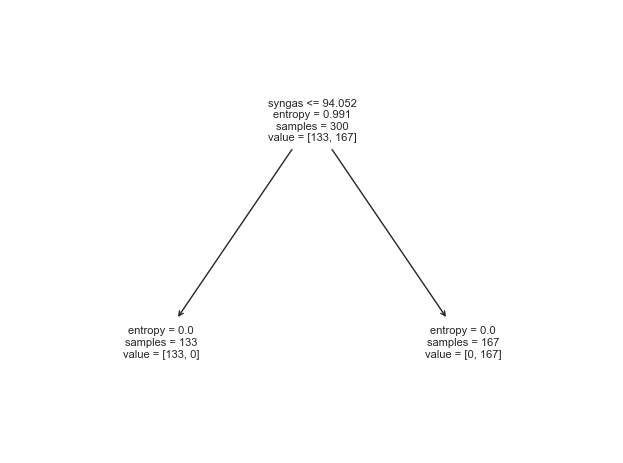

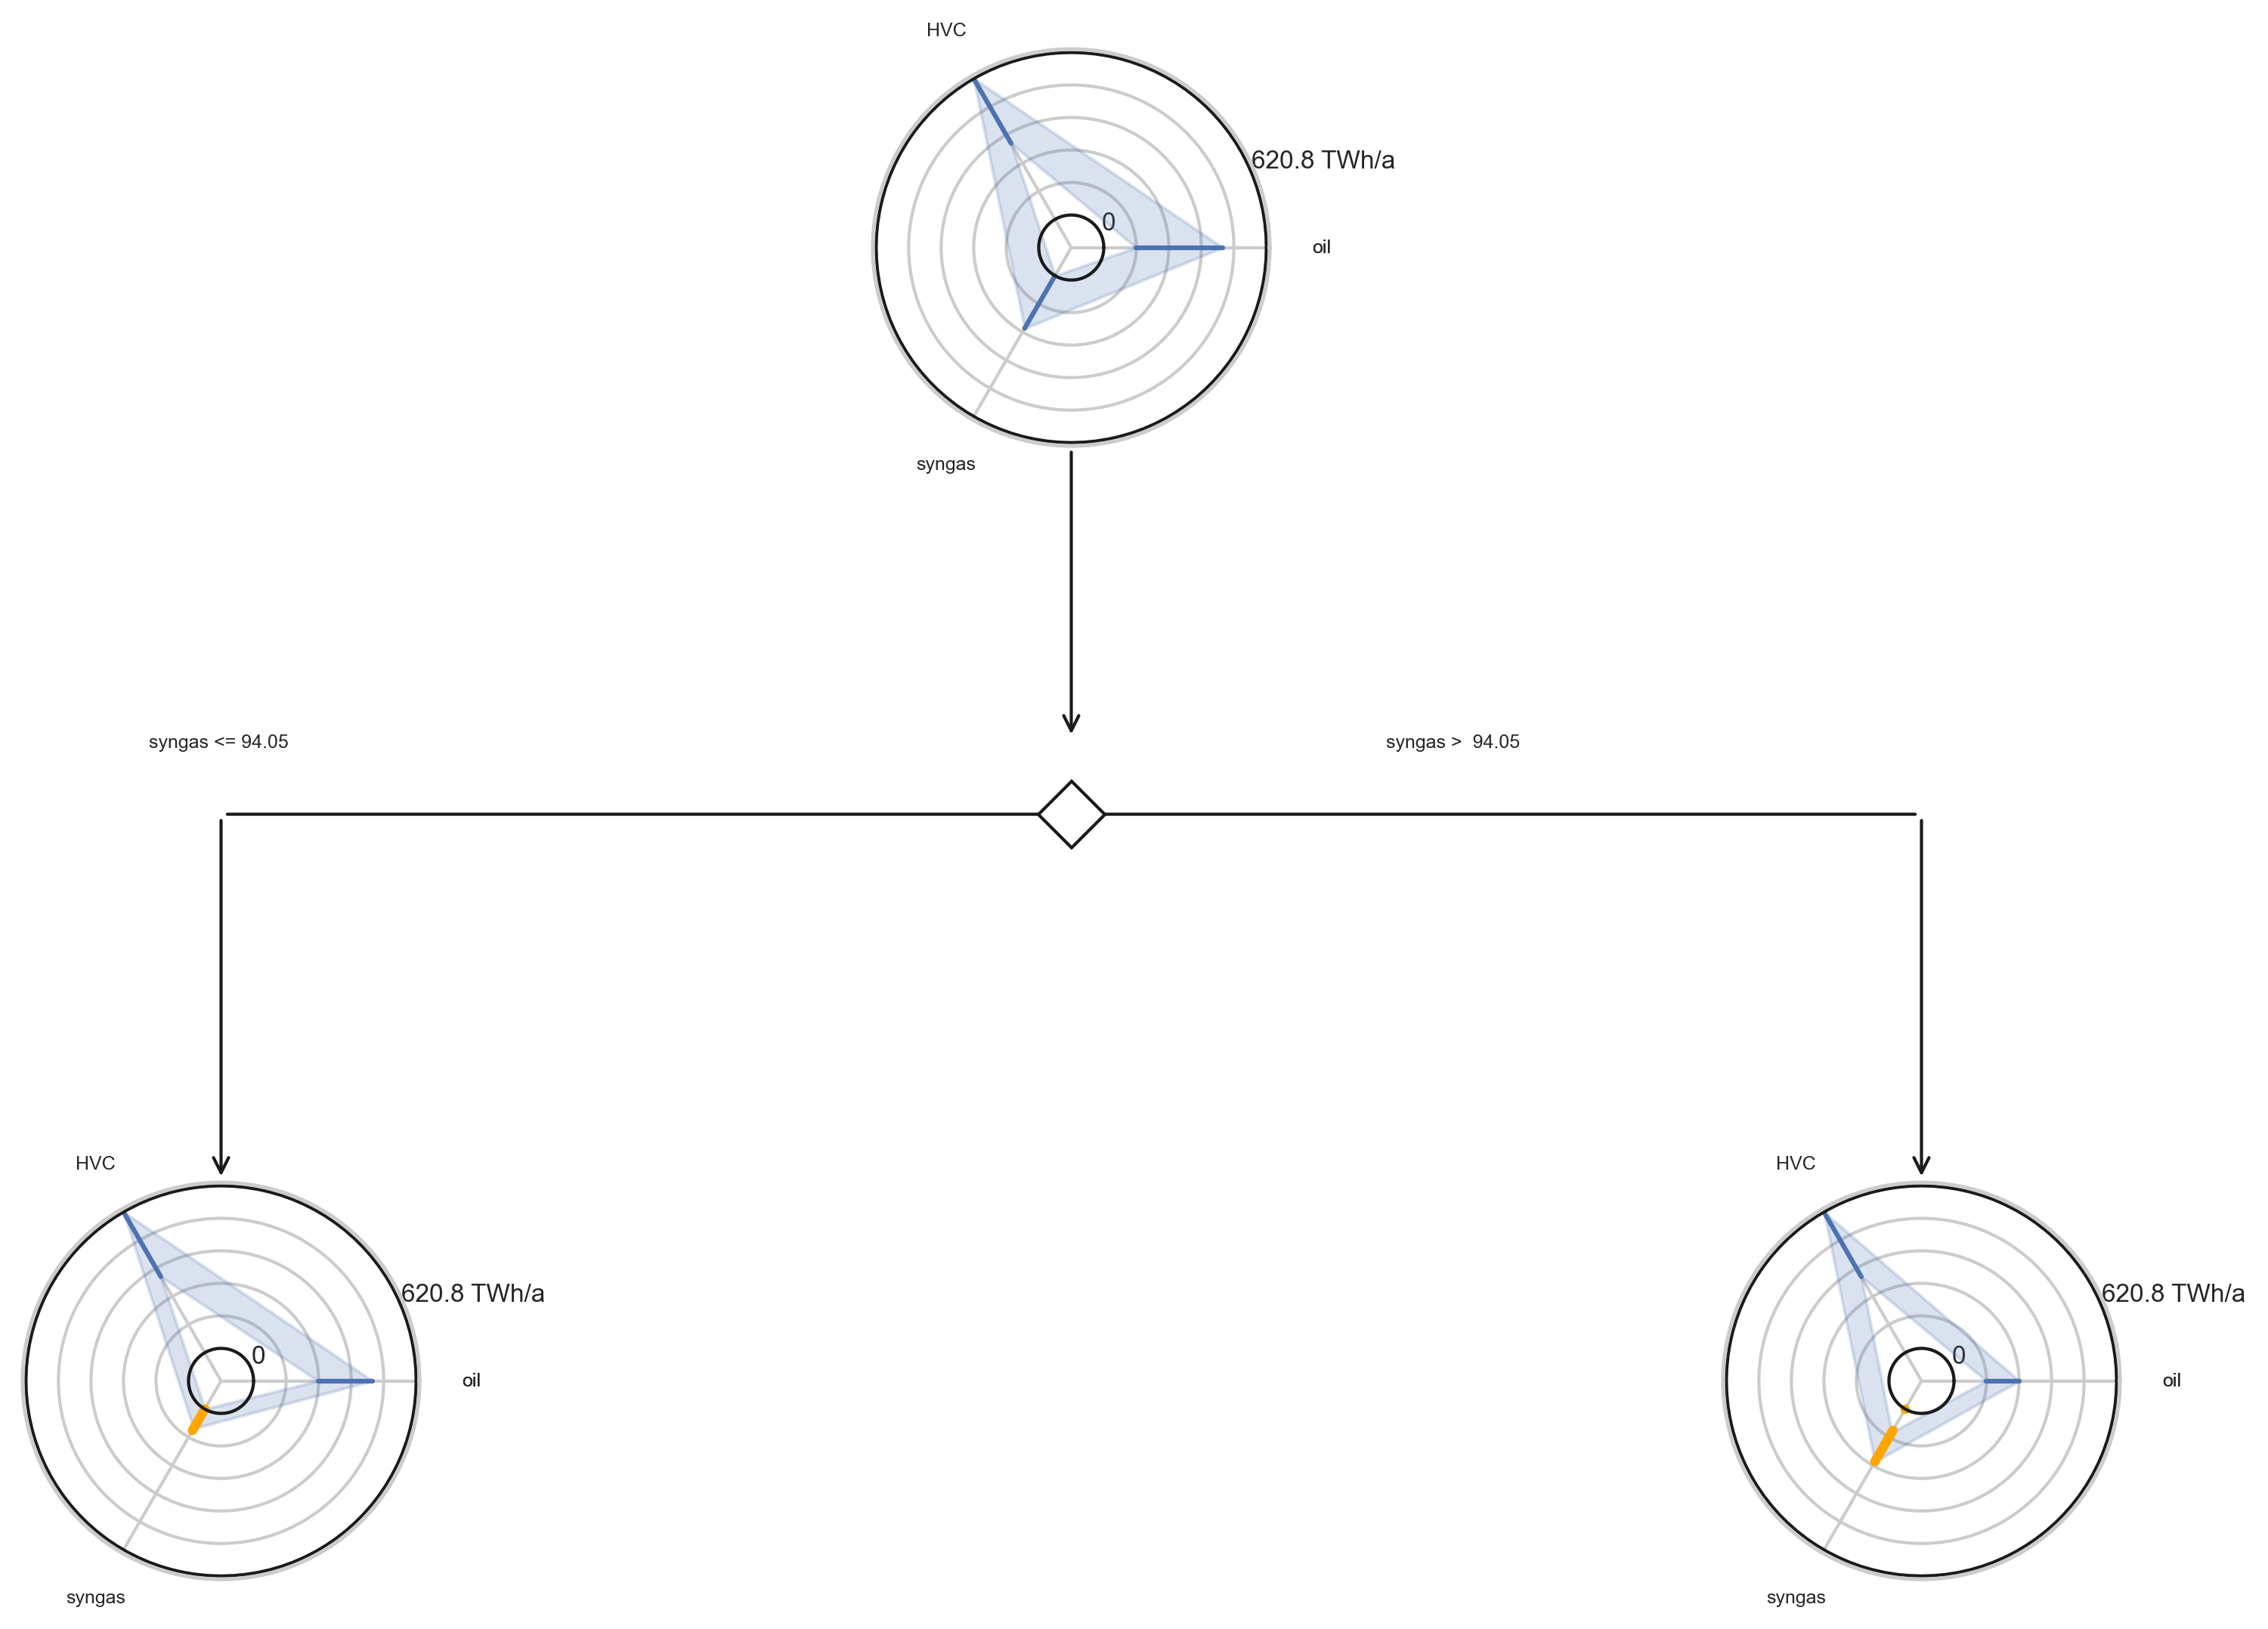

In [9]:
# Produce the interpretable tree (print_info=False to avoid printing additional information about the choic of the number of clusters)
df_filtered_with_cluster, nodes, choices, decision_space = produce_interpretable_tree(df_filtered, CATEGORY_NAMES, NUMBER_OF_CLUSTERS, plot_all_spyders=False, figure_folder=folder, absolute_values=True, colors=['orange', 'orange', 'orange'], print_info=False)

# Save the filtered dataframe with the cluster column
df_filtered_with_cluster.to_csv(folder+"df_filtered_with_cluster.csv", sep = ";", index=False)

Print the choices needed to do the regret calculation in EuSysMod

In [10]:
print(choices)

{0: [' syngas <= 94.05', ' syngas >  94.05']}


Calculate the geometric median of each cluster

In [17]:
median_data = [] # List to store the results
dimensions = [dim for dim in list(df_filtered_with_cluster.columns) if "cluster" not in dim] # Extract the dimensions from the DataFrame

for cluster in range(NUMBER_OF_CLUSTERS):
    df_cluster = df_filtered_with_cluster[df_filtered_with_cluster['cluster_final'] == cluster] # Extract the points of the cluster

    # Extract the 3D points from the DataFrame
    points = df_cluster[dimensions].values

    # Calculate the pairwise distances between the points
    distances = cdist(points, points, metric='euclidean')

    # Calculate the sum of distances for each point
    sum_distances = np.sum(distances, axis=1)

    # Find the index of the point with the minimum sum of distances
    geometric_median_index = np.argmin(sum_distances)

    # Get the geometric median_df point
    geometric_median = points[geometric_median_index]

    # Find the index of the geometric median point in the original DataFrame
    index = np.where((df_filtered_with_cluster['crudeOil'] == geometric_median[0]) & (df_filtered_with_cluster['HVC'] == geometric_median[1]) & (df_filtered_with_cluster['syngas'] == geometric_median[2]))[0][0] +1

    # Append the result to the median_data list
    median_data.append([cluster, index] + list(geometric_median))

# Create a DataFrame from the median_data list
column_names = ['cluster', 'index'] + dimensions
median_df = pd.DataFrame(median_data, columns=column_names)


print(median_df)


   cluster  index    crudeOil         HVC      syngas
0        0    111  353.732822  487.839320    0.764727
1        1    206  182.083283  477.680652  181.553324


# Plot the results

### Create a 3D scatter plot
That only makes sence if the filtered data contains 3 dimension

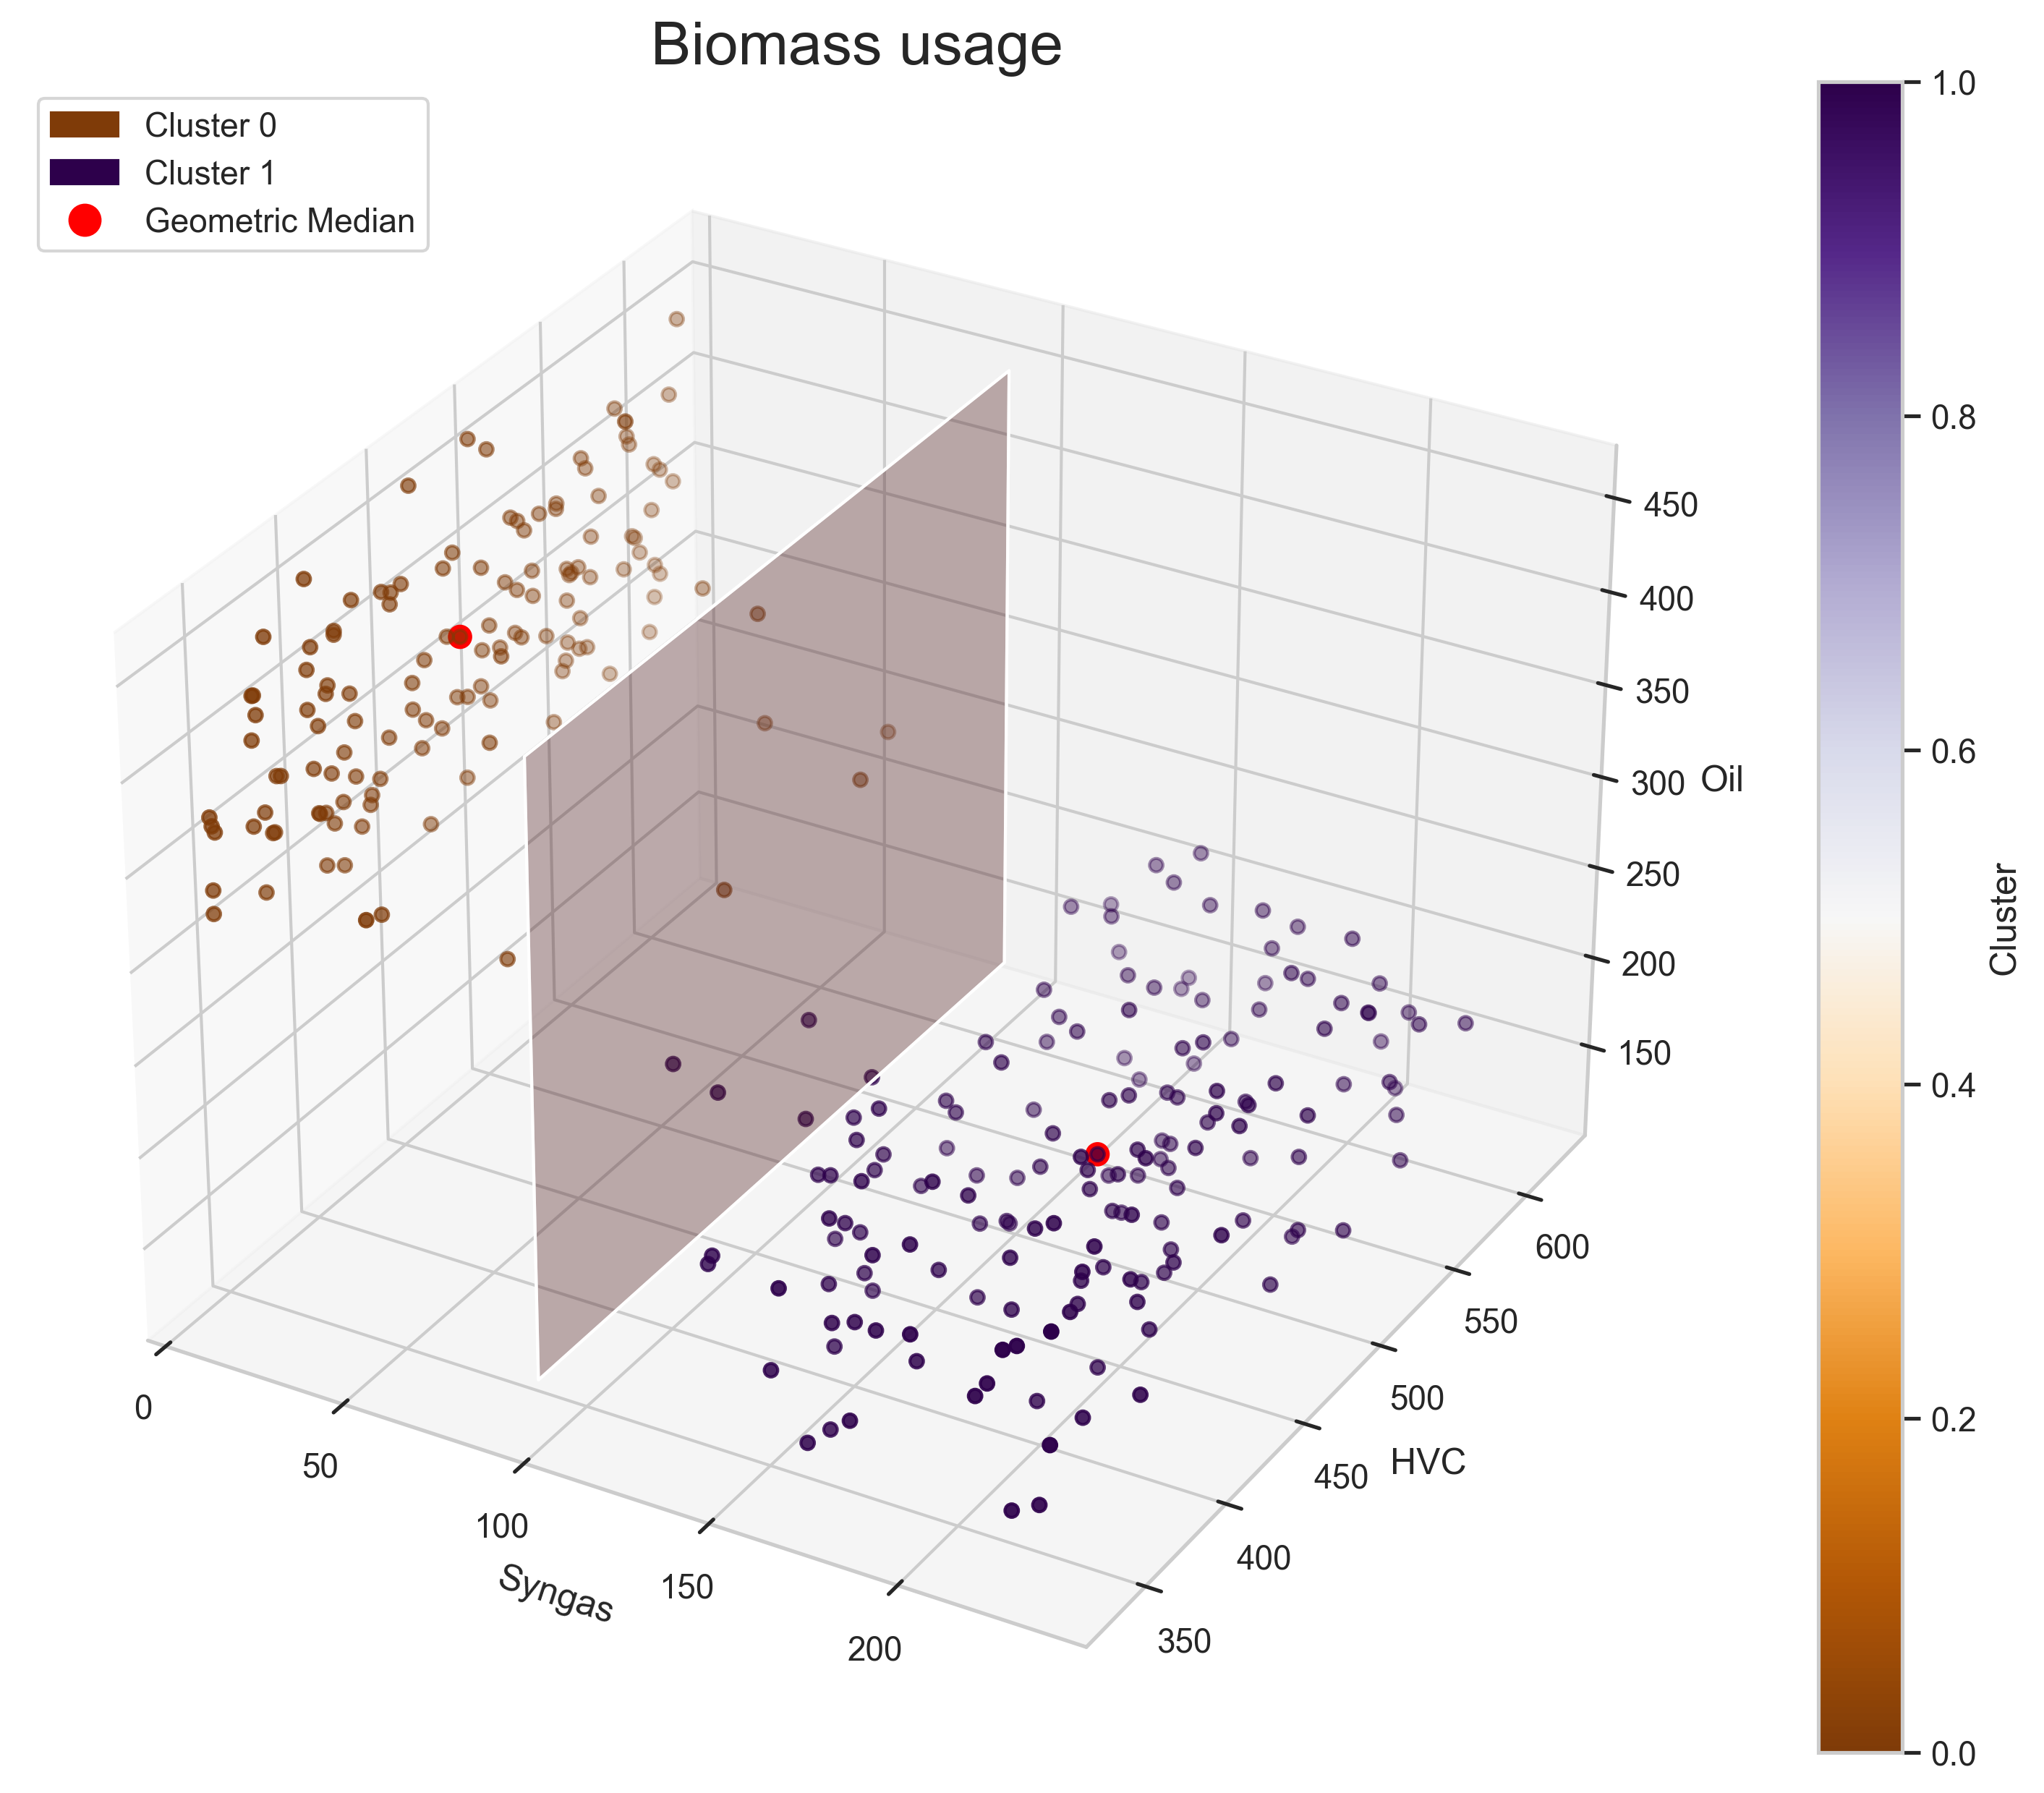

In [63]:
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# Create a 3D scatter plot
fig = plt.figure(figsize=(15, 10), dpi=300)
ax = fig.add_subplot(111, projection='3d')

# Plot the dots
dots = ax.scatter(df_filtered_with_cluster['syngas'], df_filtered_with_cluster['HVC'], df_filtered_with_cluster['crudeOil'], c=df_filtered_with_cluster['cluster_final'], cmap='PuOr')
medians = ax.scatter(median_df['syngas'], median_df['HVC'], median_df['crudeOil'], c = 'red', alpha=1, s=50)


# Define funcitons to plot the planes in the 3D space to show the decision tree splits
def plot_x_plane(ax, x_value, color='r', alpha=0.5):
    yy, zz = np.meshgrid(
        np.linspace(df_filtered_with_cluster['HVC'].min(), df_filtered_with_cluster['HVC'].max(), 10),
        np.linspace(df_filtered_with_cluster['crudeOil'].min(), df_filtered_with_cluster['crudeOil'].max(), 10)
    )
    xx = np.full(yy.shape, x_value)
    ax.plot_surface(xx, yy, zz, color=color, alpha=alpha, rstride=100, cstride=100)

def plot_y_plane(ax, y_value, color='r', alpha=0.5):
    xx, zz = np.meshgrid(
        np.linspace(df_filtered_with_cluster['syngas'].min(), df_filtered_with_cluster['syngas'].max(), 10),
        np.linspace(df_filtered_with_cluster['crudeOil'].min(), df_filtered_with_cluster['crudeOil'].max(), 10)
    )
    yy = np.full(xx.shape, y_value)
    ax.plot_surface(xx, yy, zz, color=color, alpha=alpha, rstride=100, cstride=100)

def plot_z_plane(ax, z_value, color='r', alpha=0.5):
    xx, yy = np.meshgrid(
        np.linspace(df_filtered_with_cluster['syngas'].min(), df_filtered_with_cluster['syngas'].max(), 10),
        np.linspace(df_filtered_with_cluster['HVC'].min(), df_filtered_with_cluster['HVC'].max(), 10)
    )
    zz = np.full(xx.shape, z_value)
    ax.plot_surface(xx, yy, zz, color=color, alpha=alpha, rstride=100, cstride=100)
    
# Plot the decision tree split as planes
for cluster, choice in choices.items():
    for condition in choice:
        column, operator, value = condition.split()
        if column == "syngas":
            plot_x_plane(ax, x_value=float(value), color='r', alpha=0.2)
        elif column == 'HVC':
            plot_y_plane(ax, y_value=float(value), color='r', alpha=0.2)
        elif column == 'oil':
            plot_z_plane(ax, z_value=float(value), color='r', alpha=0.2)
            

# Set labels and title
ax.set_xlabel('Syngas')
ax.set_ylabel('HVC')
ax.set_zlabel('Oil')
ax.set_title('Biomass usage', fontsize=20)
ax.set_xlim(0)

# Add a colorbar
plt.colorbar(dots, ax=ax, label='Cluster')

# Get colors from the colormap
cmap = plt.get_cmap('PuOr')
cluster_0_color = cmap(0 / 1)  # Normalize 0 to the range of the colormap
cluster_1_color = cmap(1 / 1)  # Normalize 1 to the range of the colormap

# Create custom legend handles
handles = [
    mpatches.Patch(color=cluster_0_color, label='Cluster 0'),
    mpatches.Patch(color=cluster_1_color, label='Cluster 1'),
    mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=10, label='Geometric Median')
]

# Add the legend
ax.legend(handles=handles, loc='upper left')


plt.savefig("biomass_results/3D-tree.svg",  format="svg")
plt.savefig("biomass_results/3D-tree.pdf")

# Show the plot
plt.show()




## Create 2D cuts 

Define function

In [64]:
## Create a 2D side view plot
def create_2D_side_view_plot(df_filtered_with_cluster, median_df, choices, X_AXIS, Y_AXIS):
    fig = plt.figure(figsize=(10, 10), dpi=300)
    ax = fig.add_subplot(111)

    # Plot the side view (2D)
    dots = ax.scatter(df_filtered_with_cluster[X_AXIS], df_filtered_with_cluster[Y_AXIS], c=df_filtered_with_cluster['cluster_final'], cmap='PuOr', alpha=0.6)
    dots= ax.scatter(df_filtered_with_cluster[X_AXIS], df_filtered_with_cluster[Y_AXIS], c='black', alpha=0.1)
    median = ax.scatter(median_df[X_AXIS], median_df[Y_AXIS], c = 'red')


    # Plot the planes on the 2D side view
    for i, choice in choices.items():
        for condition in choice:
            column, operator, value = condition.split()
            value = float(value)
            if column == X_AXIS:
                ax.axvline(x=value, color='r', linestyle='--', alpha=0.5)
                # y_min, y_max =  255, 470  # range of y values
                # ax.plot([value, value], [y_min, y_max], color='r', linestyle='--', alpha=0.5)

            elif column == Y_AXIS:
                ax.axhline(y=value, color='r', linestyle='--', alpha=0.5)


    # Set labels and title for the 2D plot
    ax.set_xlabel(X_AXIS)
    ax.set_ylabel(Y_AXIS)
    ax.set_title('Biomass usage (2D cut)')

    # Get colors from the colormap
    cmap = plt.get_cmap('PuOr')
    cluster_0_color = cmap(0 / 1)  # Normalize 0 to the range of the colormap
    cluster_1_color = cmap(1 / 1)  # Normalize 1 to the range of the colormap

    # Create custom legend handles
    handles = [
        mpatches.Patch(color=cluster_0_color, label='Cluster 0'),
        mpatches.Patch(color=cluster_1_color, label='Cluster 1'),
        mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=10, label='Geometric Median')
    ]

    # Add the legend
    ax.legend(handles=handles, loc='upper left')


    plt.savefig(f"biomass_results/2D-tree_{X_AXIS}_{Y_AXIS}.svg",  format="svg")
    plt.savefig(f"biomass_results/2D-tree_{X_AXIS}_{Y_AXIS}.pdf")

    # Show the plots
    plt.show()


Create 2D plots

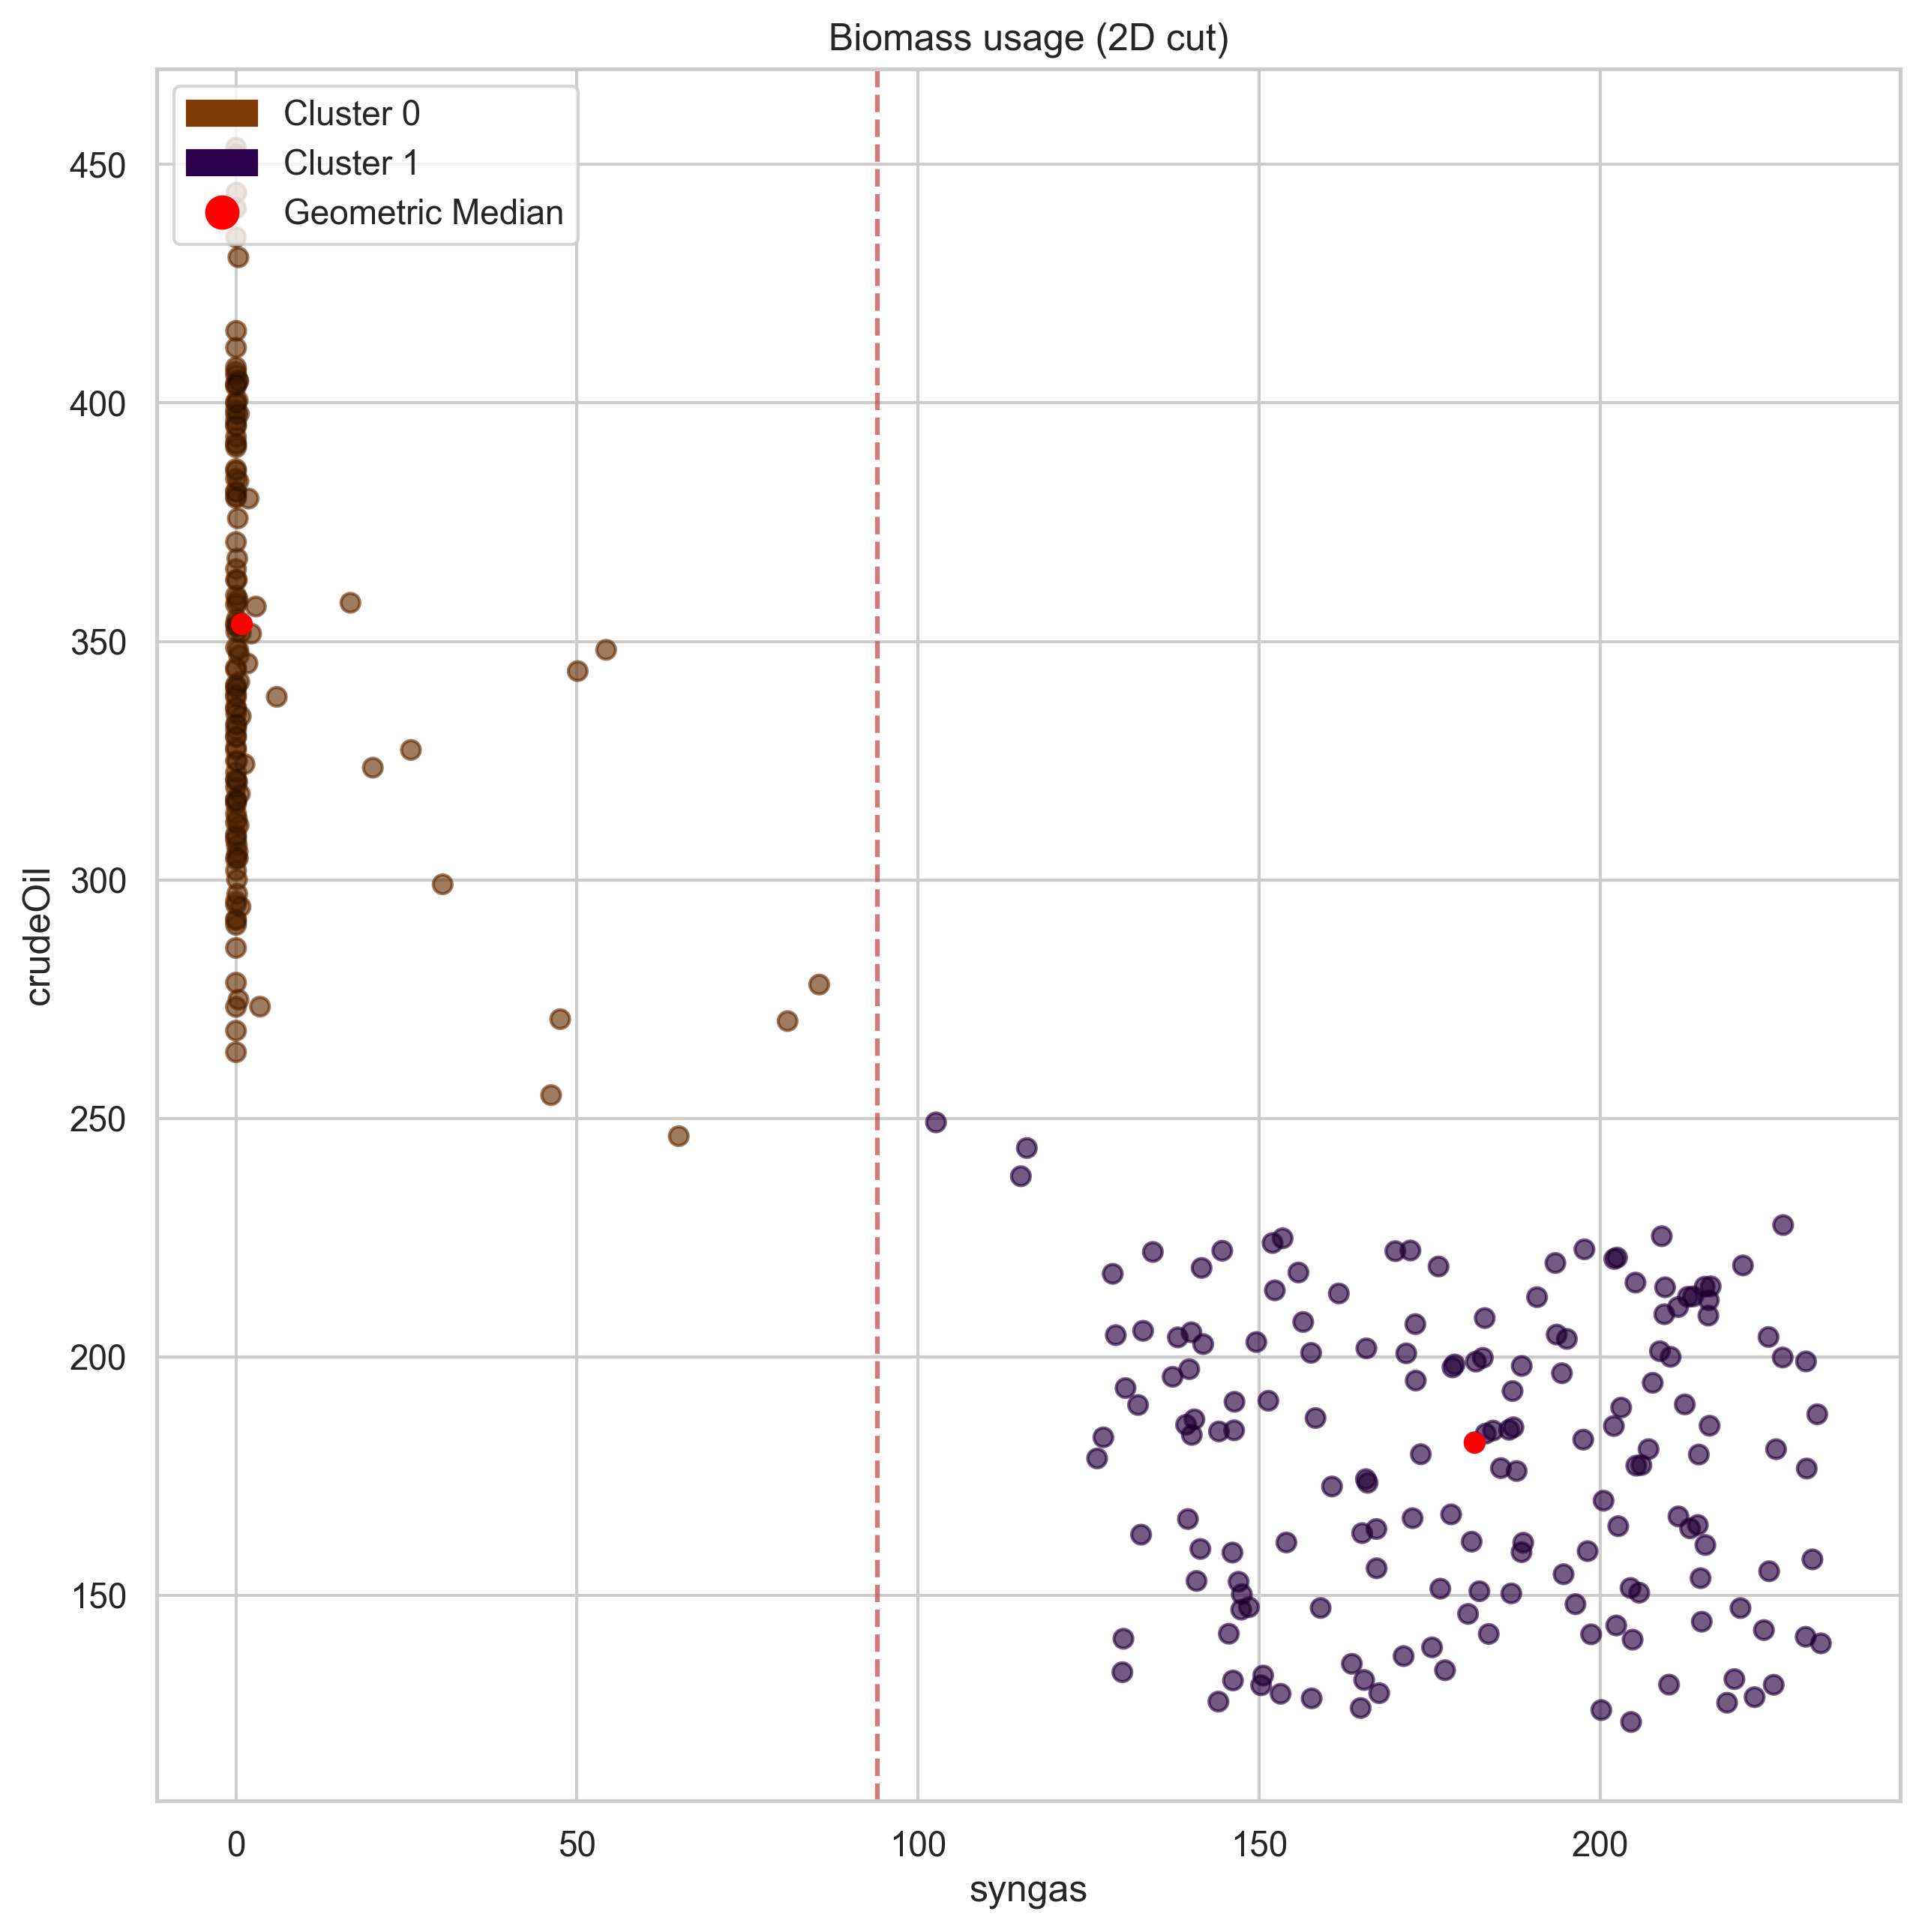

In [65]:
# Specify cut plane
X_AXIS = 'syngas'
Y_AXIS = 'crudeOil'

create_2D_side_view_plot(df_filtered_with_cluster, median_df, choices, X_AXIS, Y_AXIS)

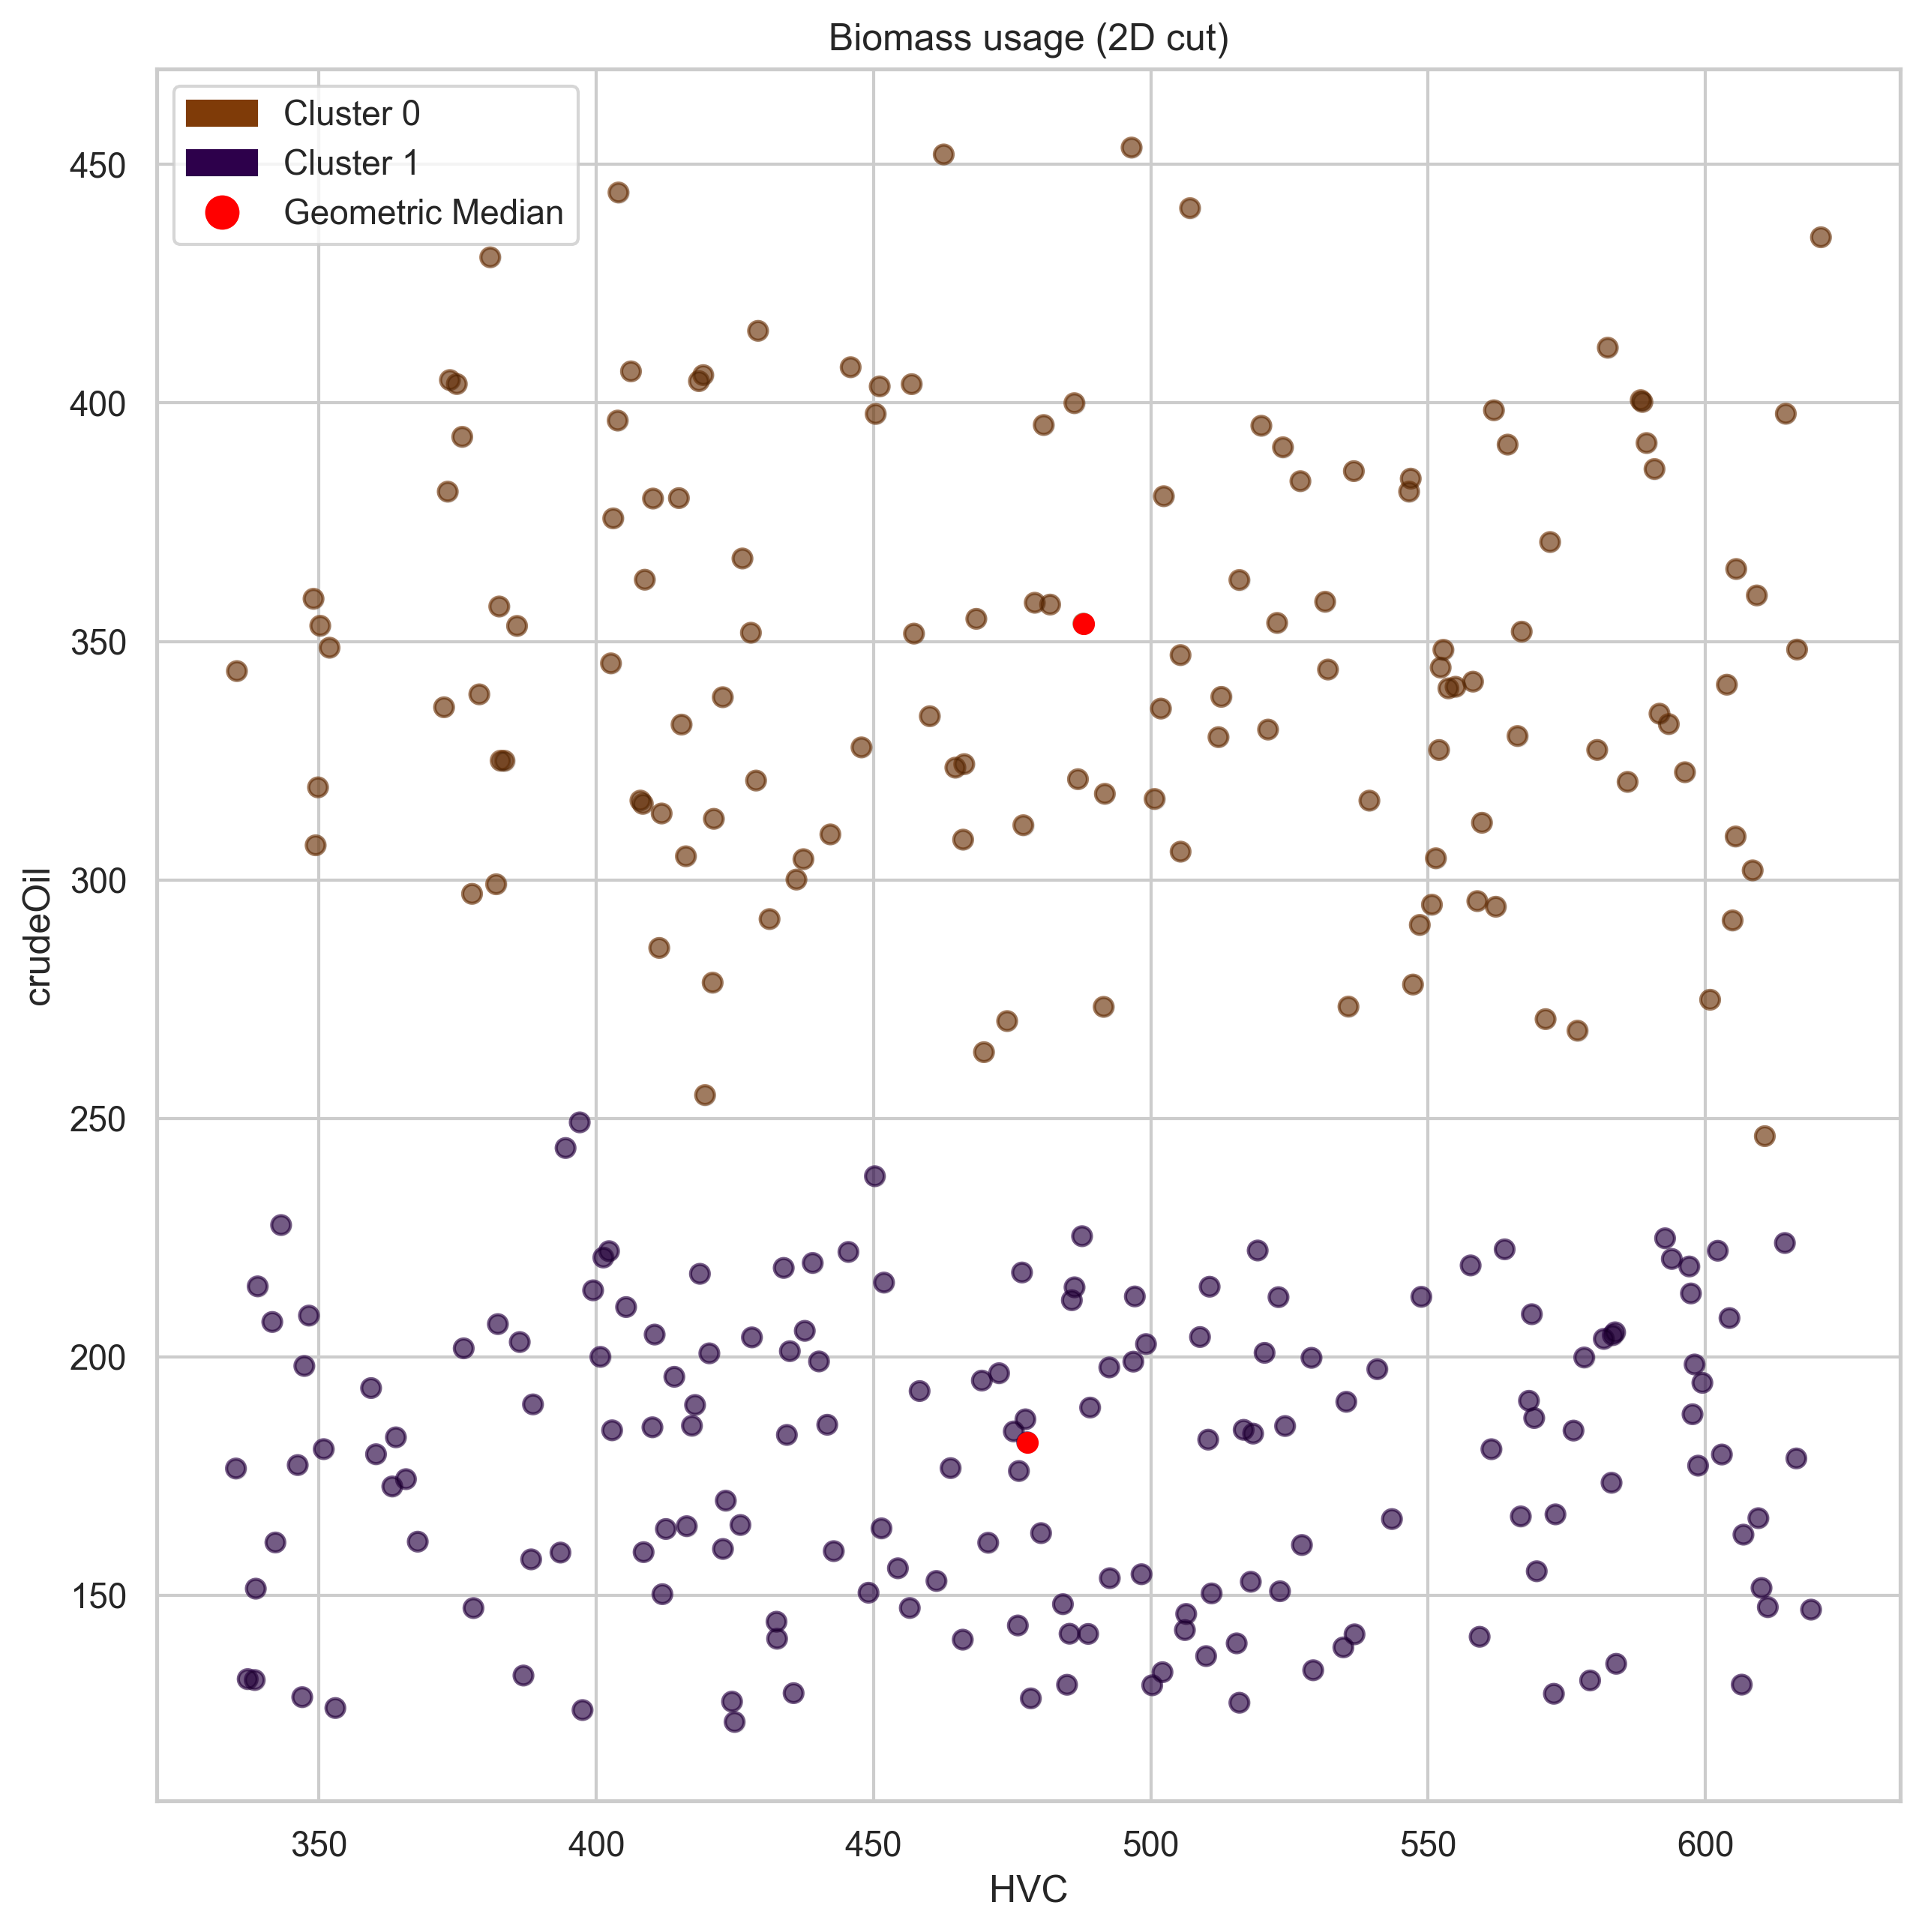

In [66]:
# Specify cut plane
X_AXIS = 'HVC'
Y_AXIS = 'crudeOil'

create_2D_side_view_plot(df_filtered_with_cluster, median_df, choices, X_AXIS, Y_AXIS)

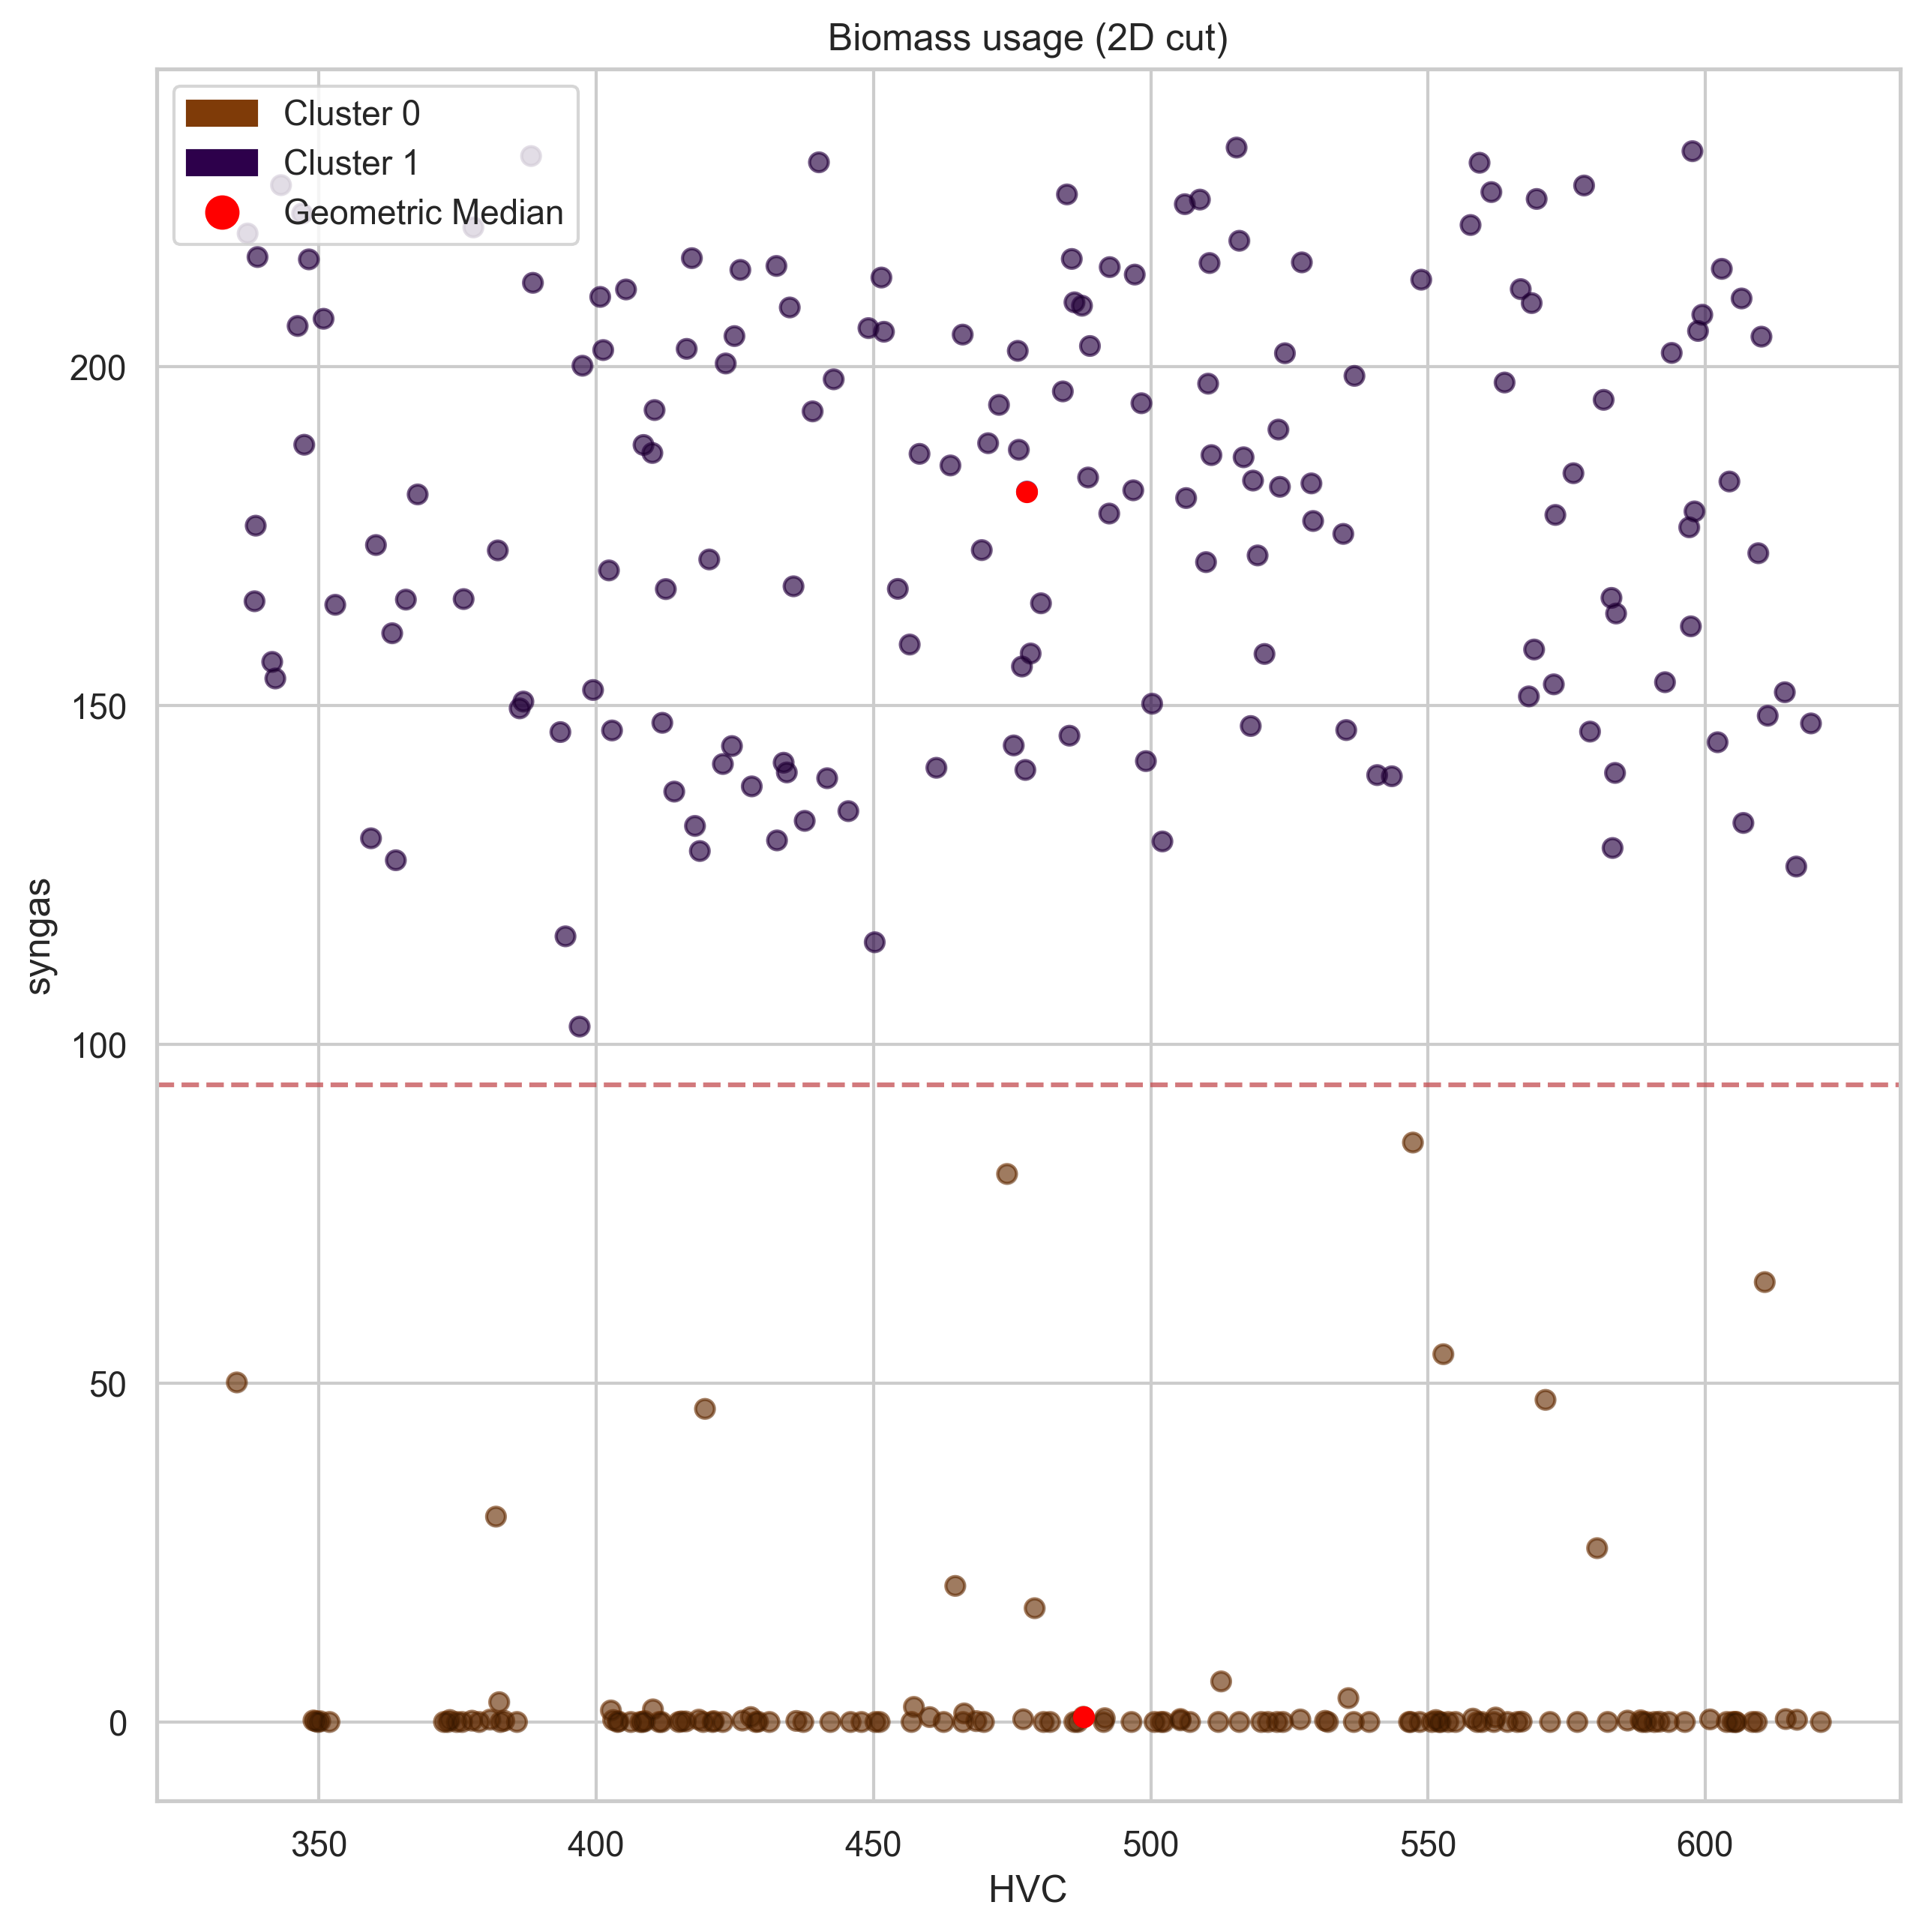

In [67]:
# Specify cut plane
X_AXIS = 'HVC'
Y_AXIS = 'syngas'

create_2D_side_view_plot(df_filtered_with_cluster, median_df, choices, X_AXIS, Y_AXIS)

In [68]:

df = pd.read_csv("usage_files/biomassUsage_iteration_1.csv", sep=",") # Read the CSV file

for i in range(2,301, 1):
    file_location = f"usage_files/biomassUsage_iteration_{i}.csv"
    df  += pd.read_csv(file_location, sep=",") # Read the CSV file

df

,carrier,pyrolysisOil,biomassToHvc,chp,boilerDh,boilerSpace,boilerProLow,boilerProMed,boilerProHigh,biochemicalWoodOil,liquefaction,digestion,gasification,carbonization,pyrolysisCoal
0,woodwoodwoodwoodwoodwoodwoodwoodwoodwoodwoodwo...,-0.322586,-144331.341575,-16.080265,-2.362308,-0.151153,-5.076553,-0.079519,-6.297121,-0.181234,0.000000,0.000000,-1.867607,0.000000,-8.028466
1,greenWastegreenWastegreenWastegreenWastegreenW...,-49558.726849,0.000000,-40.840989,-3.841570,0.000000,-9.103126,-0.180445,-16.307506,0.000000,-4.186219,-5.186094,-3.728538,0.000000,0.000000
2,manuremanuremanuremanuremanuremanuremanuremanu...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-23396.601816,-42.886587,-30449.597378,0.000000,0.000000
3,sludgesludgesludgesludgesludgesludgesludgeslud...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2799.168491,-72.801762,-3.395410,0.000000,0.000000
4,digestatedigestatedigestatedigestatedigestated...,0.000000,0.000000,-37.705031,-3.795654,0.000000,-9.195251,-0.176125,-16.591420,0.000000,0.000000,0.000000,-4.024880,-0.789535,0.000000
